# Análisis de Importancia de Features con XGBoost

Análisis usando XGBoost para determinar la importancia de las features especificadas.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import xgboost as xgb
from xgboost import plot_importance
import warnings
warnings.filterwarnings('ignore')
import shap

In [2]:
import os
import sys

project_root = os.path.abspath(os.path.join(os.path.dirname('__file__'), '..', '..'))
os.chdir(project_root)

# Añadir el directorio raíz al path de Python
if project_root not in sys.path:
    sys.path.append(project_root)

In [3]:
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.style.use('default')

In [4]:
# Columnas seleccionadas
features = [
    'year', 'id_grado', 'sede', 'año_ingreso', 'antigüedad', 'género', 'edad_estudiante',
    'demuestra_confianza', 'país_origen', 'estrato', 'tipo_vivienda', 'zona_vivienda',
    'horas_semana_estudio_casa', 'interés_estudios_superiores', 'medio_transporte',
    'apoyo_familiar', 'total_hermanos', 'familia', 'actividades_extracurriculares',
    'enfermedades', 'proyección_vocacional', 'participación_clase', 'nee',
    'valoración_emocional', 'nivel_motivación', 'id_asignatura', 'period', 'dimensión',
    'count_login', 'max_inactividad', 'count_login_mon', 'count_login_tue', 
    'count_login_wed', 'count_login_thu', 'count_login_fri', 'count_login_sat', 
    'count_login_sun', 'count_jornada_madrugada', 'count_jornada_mañana', 
    'count_jornada_tarde', 'count_jornada_noche', 'intensidad', 'id_docente', 
    'rol_adicional', 'nivel_educativo', 'total_subjects', 'total_hours', 
    'unique_students_count', 'update_events_count', 'years_experience_ficc',
    'years_experience_total', 'age', 'count_evaluation', 'count_collaboration', 
    'count_content', 'count_in_english', 'count_interactive', 'num_modules',
    'num_modules_updated', 'num_teacher_views_before_planned_start_date', 
    'teacher_total_updates', 'teacher_total_views', 'student_total_views', 
    'student_total_interactions', 'min_days_since_creation', 'max_days_since_creation', 
    'avg_days_since_creation', 'median_days_since_creation', 'avg_days_since_last_update', 
    'median_days_since_last_update', 'percent_evaluation', 'percent_collaboration', 
    'percent_content', 'percent_in_english', 'percent_interactive', 'percent_updated', 
    'num_students', 'num_students_viewed', 'num_students_interacted', 'num_modules_viewed', 
    'avg_views_per_student', 'median_views_per_student', 'avg_interactions_per_student', 
    'median_interactions_per_student', 'id_least_viewed_module', 'students_viewed_least_module', 
    'id_most_late_opened_module', 'days_before_start', 'percent_modules_out_of_date', 
    'percent_students_viewed', 'percent_students_interacted', 'percent_modules_viewed', 
    'total_modules', 'modules_viewed', 'modules_participated', 
    'percent_modules_viewed_interacciones_de_estudiantes', 'percent_modules_participated', 
    'has_viewed_all_modules', 'has_participated_all_modules', 'total_views', 
    'total_interactions', 'avg_views_per_module', 'avg_interactions_per_module', 
    'median_views_per_module', 'median_interactions_per_module', 'min_views_per_module', 
    'min_interactions_per_module', 'max_views_in_a_module', 'max_interactions_in_a_module', 
    'std_views_per_module', 'std_interactions_per_module', 'interaction_to_view_ratio', 
    'log_total_views', 'log_total_interactions', 'avg_days_before_start', 'avg_days_after_end', 
    'std_days_before_start', 'std_days_after_end', 'min_days_before_start', 'min_days_after_end', 
    'max_days_after_end', 'max_days_before_start', 'median_days_before_start', 
    'median_days_after_end', 'on_time_rate', 'late_rate', 'early_access_count', 
    'late_access_count', 'iqr_views', 'skew_views', 'kurtosis_views', 
    'relative_views_percentile', 'relative_interaction_percentile', 'zscore_views', 
    'zscore_interactions', 'mid_week_engagement', "login_consistency",
        "dia_preferido",
        "jornada_preferida",
        "login_regularity_score",
        "consecutive_days_max",
        "gaps_between_sessions_avg",
        "engagement_decay",
        "activity_percentile",
        "longest_inactivity_streak"
]

# Variable objetivo
target_column = 'nivel'

In [5]:
def cargar_datos():
    # Cargar el dataset
    df = pd.read_csv('data/interim/full_dataset_combined.csv')
    print(f"Dataset cargado: {df.shape[0]} filas, {df.shape[1]} columnas")
    return df


In [6]:
cargar_datos()

Dataset cargado: 76835 filas, 151 columnas


,documento_identificación,moodle_user_id,year,edukrea_user_id,id_grado,sede,año_ingreso,antigüedad,género,fecha_nacimiento,...,early_access_count,late_access_count,iqr_views,skew_views,kurtosis_views,relative_views_percentile,relative_interaction_percentile,zscore_views,zscore_interactions,mid_week_engagement
0,b8bd5170750ee52b2456363db9b3987fe2af7b89842474...,1561,2024,NaN,1,Fusagasugá,2023,Antiguo,Femenino,2018-05-02,...,0,0,0.0,2.4896,5.3538,80.00,83.33,0.3186,0.0668,0.0
1,b8bd5170750ee52b2456363db9b3987fe2af7b89842474...,1561,2024,NaN,1,Fusagasugá,2023,Antiguo,Femenino,2018-05-02,...,0,0,0.0,2.4896,5.3538,80.00,83.33,0.3186,0.0668,0.0
2,b8bd5170750ee52b2456363db9b3987fe2af7b89842474...,1561,2024,NaN,1,Fusagasugá,2023,Antiguo,Femenino,2018-05-02,...,0,0,0.0,2.4896,5.3538,80.00,83.33,0.3186,0.0668,0.0
3,b8bd5170750ee52b2456363db9b3987fe2af7b89842474...,1561,2024,NaN,1,Fusagasugá,2023,Antiguo,Femenino,2018-05-02,...,0,0,0.0,2.4896,5.3538,80.00,83.33,0.3186,0.0668,0.0
4,b8bd5170750ee52b2456363db9b3987fe2af7b89842474...,1561,2024,NaN,1,Fusagasugá,2023,Antiguo,Femenino,2018-05-02,...,0,0,0.0,2.4896,5.3538,80.00,83.33,0.3186,0.0668,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76830,a5607b9d2bdca49568a8b4c44925d3372790c03df27136...,2000,2025,340.0,7,Fusagasugá,2025,Nuevo,Femenino,2010-07-02,...,0,0,0.0,NaN,NaN,52.38,52.38,0.0000,0.0000,0.0
76831,a5607b9d2bdca49568a8b4c44925d3372790c03df27136...,2000,2025,340.0,7,Fusagasugá,2025,Nuevo,Femenino,2010-07-02,...,0,0,0.0,NaN,NaN,52.38,52.38,0.0000,0.0000,0.0
76832,a5607b9d2bdca49568a8b4c44925d3372790c03df27136...,2000,2025,340.0,7,Fusagasugá,2025,Nuevo,Femenino,2010-07-02,...,0,0,0.0,NaN,NaN,52.38,52.38,0.0000,0.0000,0.0
76833,a5607b9d2bdca49568a8b4c44925d3372790c03df27136...,2000,2025,340.0,7,Fusagasugá,2025,Nuevo,Femenino,2010-07-02,...,0,0,0.0,NaN,NaN,52.38,52.38,0.0000,0.0000,0.0


In [7]:
def preprocesar_datos(df):
    # Crear una copia para trabajar
    df_processed = df.copy()

    # Remover filas con valores nulos en las variables objetivo
    df_processed = df_processed.dropna(subset=['nivel'])
    print(f"Filas después de remover nulos en nivel: {df_processed.shape[0]}")

    # Separar características numéricas y categóricas
    numeric_features = []
    categorical_features = []

    for col in features:
        if col in df_processed.columns:
            if df_processed[col].dtype in ['object', 'category']:
                categorical_features.append(col)
            else:
                numeric_features.append(col)

    print(f"Características numéricas: {len(numeric_features)}")
    print(f"Características categóricas: {len(categorical_features)}")
    
    # Manejar valores nulos en características categóricas
    for col in categorical_features:
        if df_processed[col].isnull().sum() > 0:
            df_processed[col].fillna('Desconocido', inplace=True)
    
    # Codificar variables categóricas
    label_encoders = {}
    for col in categorical_features:
        le = LabelEncoder()
        df_processed[col] = le.fit_transform(df_processed[col].astype(str))
        label_encoders[col] = le
    return df_processed, label_encoders

In [8]:
def entrenar_xgboost(X, y):
    """
    Entrena un modelo XGBoost con codificación fija para la variable 'nivel':
    Bajo = 0, Básico = 1, Alto = 2, Superior = 3
    """
    # Codificación fija de la variable 'nivel'
    nivel_ordenado = {
        "Bajo": 0,
        "Básico": 1,
        "Alto": 2,
        "Superior": 3
    }

    if y.dtype == 'object' or y.dtype.name == 'category':
        if not set(y.unique()).issubset(set(nivel_ordenado.keys())):
            raise ValueError("⚠️ Hay valores en 'nivel' que no están en el mapeo definido.")
        y_encoded = y.map(nivel_ordenado)
        le_target = nivel_ordenado  # Solo para referencia
        print("🎯 Codificación fija de 'nivel':")
        for k, v in nivel_ordenado.items():
            print(f"   {k} -> {v}")
    else:
        y_encoded = y
        le_target = None

    # Verificar estratificación
    unique_values, counts = np.unique(y_encoded, return_counts=True)
    min_samples = min(counts)

    if min_samples >= 2:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
        )
        print(f"✅ División con estratificación (min samples por clase: {min_samples})")
    else:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y_encoded, test_size=0.2, random_state=42
        )
        print(f"⚠️  División sin estratificación (algunas clases tienen solo {min_samples} ejemplo(s))")

    # Entrenar modelo
    model = xgb.XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        random_state=42,
        eval_metric='mlogloss'
    )

    model.fit(X_train, y_train)

    # Predicciones
    y_pred = model.predict(X_test)

    # Reconstruir etiquetas originales si usaste codificación
    if le_target is not None:
        inv_map = {v: k for k, v in le_target.items()}
        y_test_original = y_test.map(inv_map)
        y_pred_original = pd.Series(y_pred).map(inv_map)
    else:
        y_test_original = y_test
        y_pred_original = y_pred

    # Métricas
    accuracy = accuracy_score(y_test, y_pred)
    print(f"📈 Precisión en test: {accuracy:.4f}")

    return model, X_test, y_test, y_pred, y_test_original, y_pred_original, accuracy, le_target

In [ ]:
def visualizar_resultados(model, feature_names, nombre_modelo, y_test, y_pred, top_n=15):
    # Obtener importancia de características
    feature_importance = model.feature_importances_
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)
    
    # Crear figura con subplots
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    fig.suptitle(f'Análisis XGBoost - {nombre_modelo}', fontsize=16, fontweight='bold')
    
    # 1. Top N características más importantes
    top_features = importance_df.head(top_n)
    axes[0, 0].barh(range(len(top_features)), top_features['importance'], color='steelblue')
    axes[0, 0].set_yticks(range(len(top_features)))
    axes[0, 0].set_yticklabels(top_features['feature'], fontsize=9)
    axes[0, 0].set_xlabel('Importancia')
    axes[0, 0].set_title(f'Top {top_n} Características Más Importantes')
    axes[0, 0].invert_yaxis()
    
    # 2. Distribución de importancias
    axes[0, 1].hist(feature_importance, bins=30, color='lightcoral', alpha=0.7, edgecolor='black')
    axes[0, 1].set_xlabel('Importancia')
    axes[0, 1].set_ylabel('Frecuencia')
    axes[0, 1].set_title('Distribución de Importancias')
    axes[0, 1].axvline(feature_importance.mean(), color='red', linestyle='--', 
                       label=f'Media: {feature_importance.mean():.4f}')
    axes[0, 1].legend()
    
    # 3. Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 0])
    axes[1, 0].set_xlabel('Predicción')
    axes[1, 0].set_ylabel('Valor Real')
    axes[1, 0].set_title('Matriz de Confusión')
    
    # 4. Importancia acumulada
    importance_sorted = np.sort(feature_importance)[::-1]
    cumulative_importance = np.cumsum(importance_sorted)
    
    axes[1, 1].plot(range(1, len(cumulative_importance) + 1), cumulative_importance, 'b-', linewidth=2)
    axes[1, 1].axhline(y=0.8, color='red', linestyle='--', label='80% de importancia')
    axes[1, 1].axhline(y=0.9, color='orange', linestyle='--', label='90% de importancia')
    axes[1, 1].set_xlabel('Número de Características')
    axes[1, 1].set_ylabel('Importancia Acumulada')
    axes[1, 1].set_title('Importancia Acumulada de Características')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    archivo_png = f'xgboost_analysis_{nombre_modelo.lower().replace(" ", "_")}.png'
    plt.show()
    
    return importance_df

In [10]:
def visualizar_shap(model, X_sample, feature_names, nombre_modelo):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_sample)

    # Plot resumen
    shap.summary_plot(shap_values, X_sample, feature_names=feature_names, show=True)
    
    # Plot de barras
    shap.summary_plot(shap_values, X_sample, feature_names=feature_names, plot_type="bar", show=True)

In [11]:
def analizar_grupo_asignaturas(df_processed, feature_columns, asignaturas, nombre_grupo):
    """
    Analiza un grupo específico de asignaturas
    """
    print(f"\n{'='*80}")
    print(f"📚 ANÁLISIS PARA {nombre_grupo.upper()}")
    print(f"📚 Asignaturas: {asignaturas}")
    print(f"{'='*80}")

    # Filtrar datos por id_asignatura
    df_filtrado = df_processed[df_processed['id_asignatura'].isin(asignaturas)].copy()
    print(f"📊 Datos filtrados: {df_filtrado.shape[0]} filas de {df_processed.shape[0]} totales")
    
    if df_filtrado.empty:
        print("❌ No hay datos para este grupo de asignaturas")
        return None

    # Verificar distribución de la variable objetivo
    print(f"Distribución de 'nivel' en {nombre_grupo}:")
    distribucion = df_filtrado['nivel'].value_counts().sort_index()
    print(distribucion)
    
    if len(distribucion) < 2:
        print(f"⚠️  Solo una clase presente en {nombre_grupo}, omitiendo análisis")
        return None
    
    # Preparar características
    X = df_filtrado[feature_columns].copy()
    X = X[[col for col in feature_columns if col in df_filtrado.columns]]
    feature_names = X.columns.tolist()
    
    # Preparar variable objetivo
    y = df_filtrado['nivel'].copy()
    
    print(f"📈 Datos para el modelo: X{X.shape}, y{y.shape}")
    
    try:
        # Entrenar modelo
        model, X_test, y_test_encoded, y_pred_encoded, y_test_original, y_pred_original, accuracy, le_target = entrenar_xgboost(
            X, y
        )
        
        # Visualizar resultados
        importance_df = visualizar_resultados(
            model, feature_names, nombre_grupo, y_test_encoded, y_pred_encoded
        )

        X_sample = pd.DataFrame(X_test, columns=feature_names).sample(n=200, random_state=42)
        visualizar_shap(model, X_sample, feature_names, nombre_grupo)
        
        # Mostrar reporte de clasificación
        print(f"\n📊 Reporte de Clasificación para {nombre_grupo}:")
        print(classification_report(y_test_original, y_pred_original))
        
        # Guardar importancia de características
        archivo_csv = f'feature_importance_{nombre_grupo.lower().replace(" ", "_")}.csv'
        importance_df.to_csv(archivo_csv, index=False)
        print(f"✅ Importancia guardada en: {archivo_csv}")
        
        return {
            'grupo': nombre_grupo,
            'asignaturas': asignaturas,
            'model': model,
            'accuracy': accuracy,
            'feature_importance': importance_df,
            'classification_report': classification_report(y_test_original, y_pred_original),
            'datos_totales': df_filtrado.shape[0]
        }
        
    except Exception as e:
        print(f"❌ Error en análisis de {nombre_grupo}: {e}")
        return None

In [12]:
def main():
    print("🎯 Iniciando Análisis XGBoost por Grupos de Asignaturas")
    print("="*80)
    
    # 1. Cargar datos
    df = cargar_datos()
    
    # 2. Preprocesar datos
    df_processed, label_encoders = preprocesar_datos(df)
    
    # Verificar que tenemos id_asignatura
    if 'id_asignatura' not in df_processed.columns:
        print("❌ Error: Columna 'id_asignatura' no encontrada")
        return
    
    # 3. Definir grupos de asignaturas
    todas_asignaturas = sorted(df_processed['id_asignatura'].unique())
    grupo_basicas = [1, 2, 3, 4]
    grupo_otras = [asig for asig in todas_asignaturas if asig not in grupo_basicas]
    
    print(f"\n📚 Asignaturas en el dataset: {todas_asignaturas}")
    print(f"📚 Grupo básicas (1-4): {grupo_basicas}")
    print(f"📚 Grupo otras: {grupo_otras}")
    
    # 4. Analizar cada grupo
    resultados = []
    
    # Analizar asignaturas básicas
    if any(asig in todas_asignaturas for asig in grupo_basicas):
        asig_basicas_disponibles = [asig for asig in grupo_basicas if asig in todas_asignaturas]
        resultado_basicas = analizar_grupo_asignaturas(
            df_processed, features, asig_basicas_disponibles, "Asignaturas Básicas"
        )
        if resultado_basicas:
            resultados.append(resultado_basicas)
    
    # Analizar otras asignaturas
    if grupo_otras:
        resultado_otras = analizar_grupo_asignaturas(
            df_processed, features, grupo_otras, "Otras Asignaturas"
        )
        if resultado_otras:
            resultados.append(resultado_otras)
    
    # 5. Resumen comparativo
    print(f"\n{'='*80}")
    print("📋 RESUMEN COMPARATIVO FINAL")
    print(f"{'='*80}")
    
    for resultado in resultados:
        print(f"\n🎯 {resultado['grupo']}:")
        print(f"   - Asignaturas analizadas: {resultado['asignaturas']}")
        print(f"   - Total de registros: {resultado['datos_totales']}")
        print(f"   - Precisión del modelo: {resultado['accuracy']:.4f}")
        print(f"   - Top 5 características más importantes:")
        for i, row in resultado['feature_importance'].head(5).iterrows():
            print(f"     {i+1}. {row['feature']}: {row['importance']:.4f}")
    
    # 6. Comparación de características importantes
    if len(resultados) == 2:
        print(f"\n🔍 COMPARACIÓN DE CARACTERÍSTICAS IMPORTANTES:")
        top_basicas = set(resultados[0]['feature_importance'].head(10)['feature'].tolist())
        top_otras = set(resultados[1]['feature_importance'].head(10)['feature'].tolist())
        
        comunes = top_basicas.intersection(top_otras)
        solo_basicas = top_basicas - top_otras
        solo_otras = top_otras - top_basicas
        
        print(f"Características importantes en ambos grupos: {len(comunes)}")
        if comunes:
            print(f"   {list(comunes)[:5]}...")
        
        print(f"Solo importantes en Básicas: {len(solo_basicas)}")
        if solo_basicas:
            print(f"   {list(solo_basicas)[:5]}...")
        
        print(f"Solo importantes en Otras: {len(solo_otras)}")
        if solo_otras:
            print(f"   {list(solo_otras)[:5]}...")
    
    print(f"\n✅ Análisis completado exitosamente!")
    print(f"📁 Se generaron gráficos y archivos CSV para cada grupo")

🎯 Iniciando Análisis XGBoost por Grupos de Asignaturas
Dataset cargado: 76835 filas, 151 columnas
Filas después de remover nulos en nivel: 76835
Características numéricas: 122
Características categóricas: 23

📚 Asignaturas en el dataset: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(23)]
📚 Grupo básicas (1-4): [1, 2, 3, 4]
📚 Grupo otras: [np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(23)]

📚 ANÁLISIS PARA ASIGNATURAS BÁSICAS
📚 Asignaturas: [1, 2, 3, 4]
📊 Datos filtrados: 27135 filas de 76835 totales
Distribución de 'nivel' en Asignaturas Básicas:
nivel
Alto        16399
Bajo          616
Básico       6541
Superior     3579
Name: count, dtype: int64
📈 Datos pa

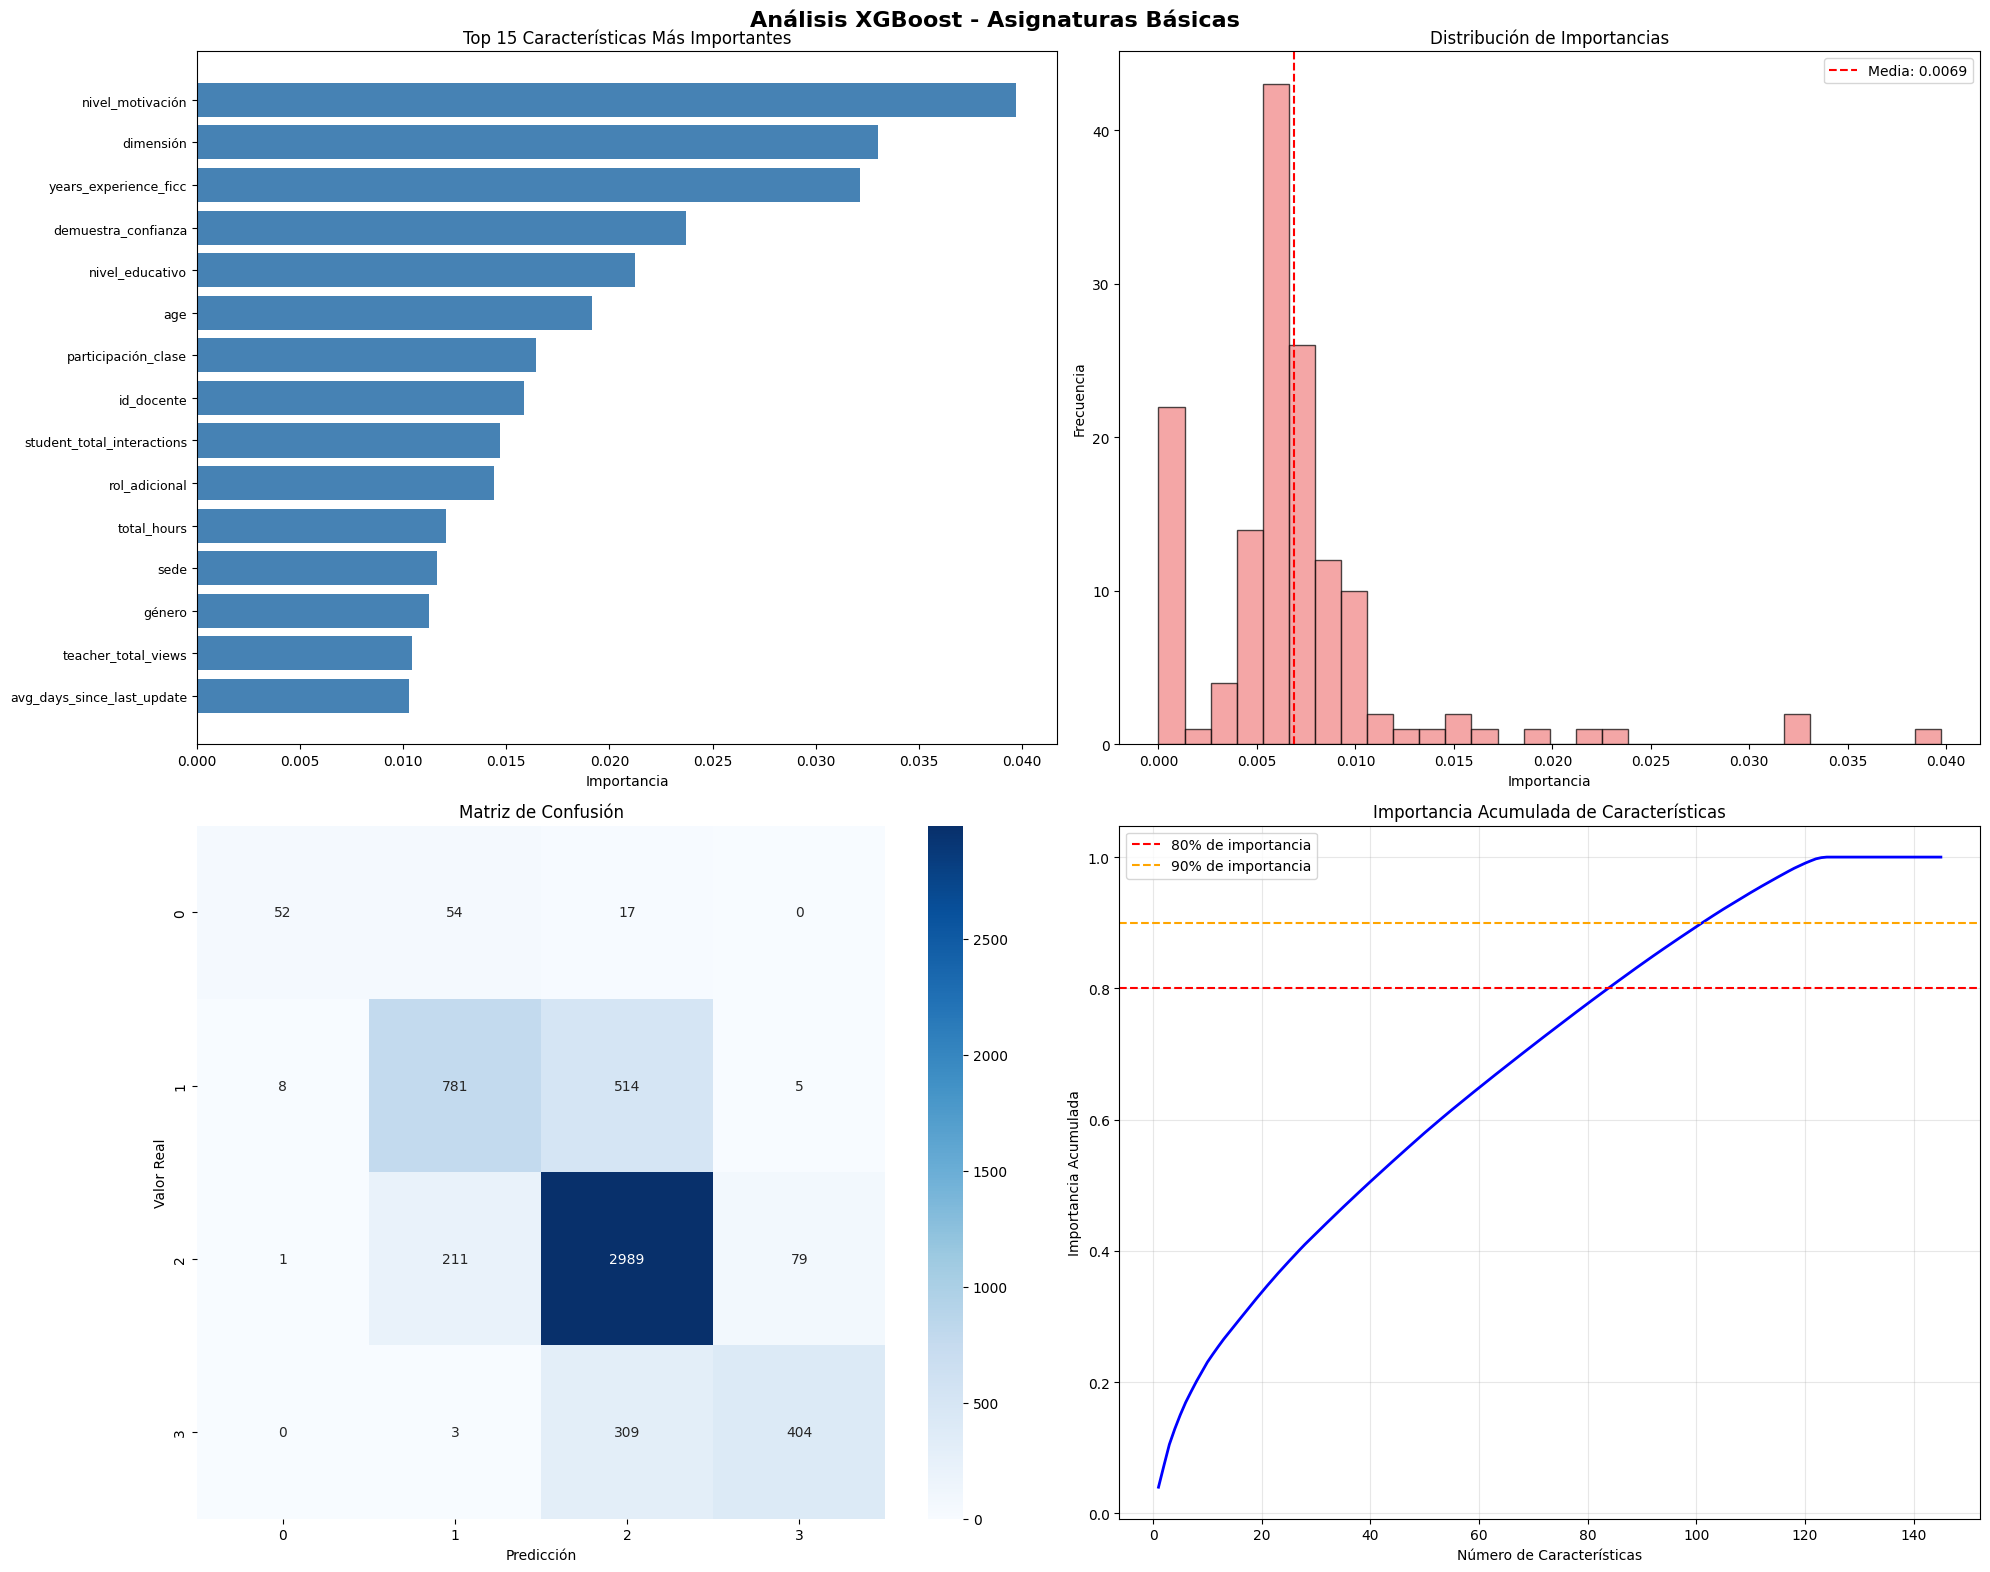

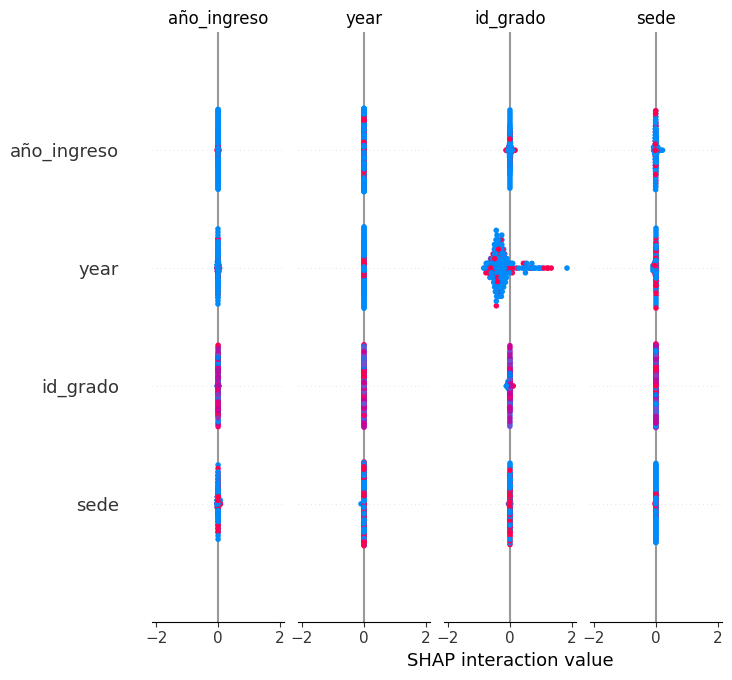

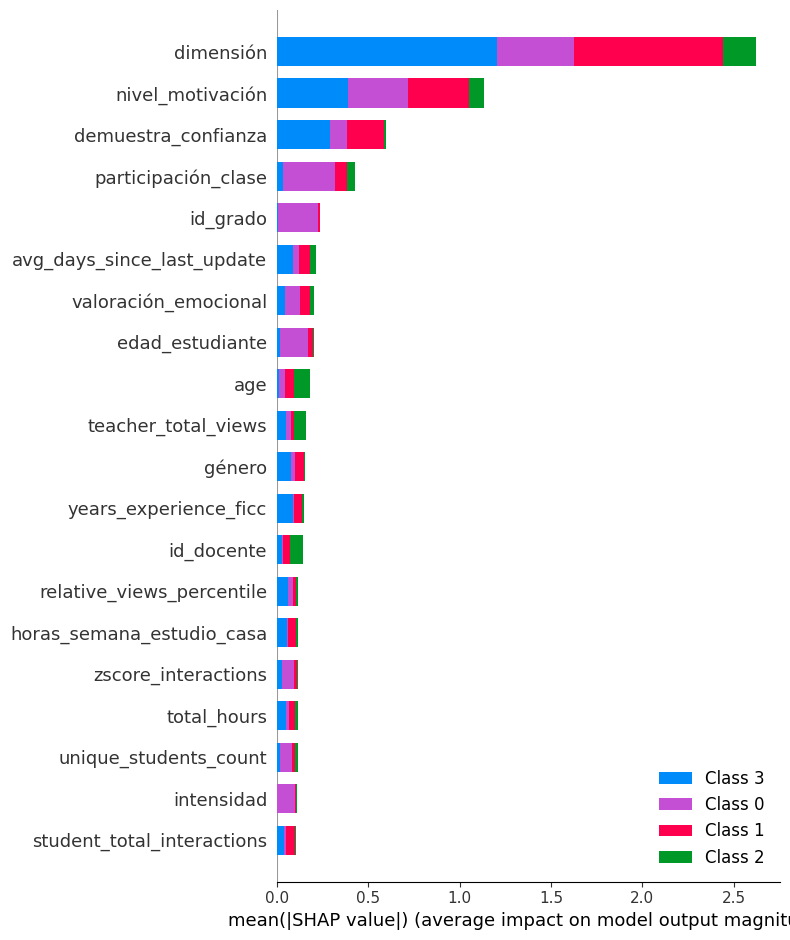


📊 Reporte de Clasificación para Asignaturas Básicas:
              precision    recall  f1-score   support

        Alto       0.78      0.91      0.84      3280
        Bajo       0.85      0.42      0.57       123
      Básico       0.74      0.60      0.66      1308
    Superior       0.83      0.56      0.67       716

    accuracy                           0.78      5427
   macro avg       0.80      0.62      0.68      5427
weighted avg       0.78      0.78      0.77      5427

✅ Importancia guardada en: feature_importance_asignaturas_básicas.csv

📚 ANÁLISIS PARA OTRAS ASIGNATURAS
📚 Asignaturas: [np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(23)]
📊 Datos filtrados: 49700 filas de 76835 totales
Distribución de 'nivel' en Otras Asignaturas:
nivel
Alto        34087
Bajo          576
Básico       6617
Superior     8420
Name: count, dtype: int64
📈

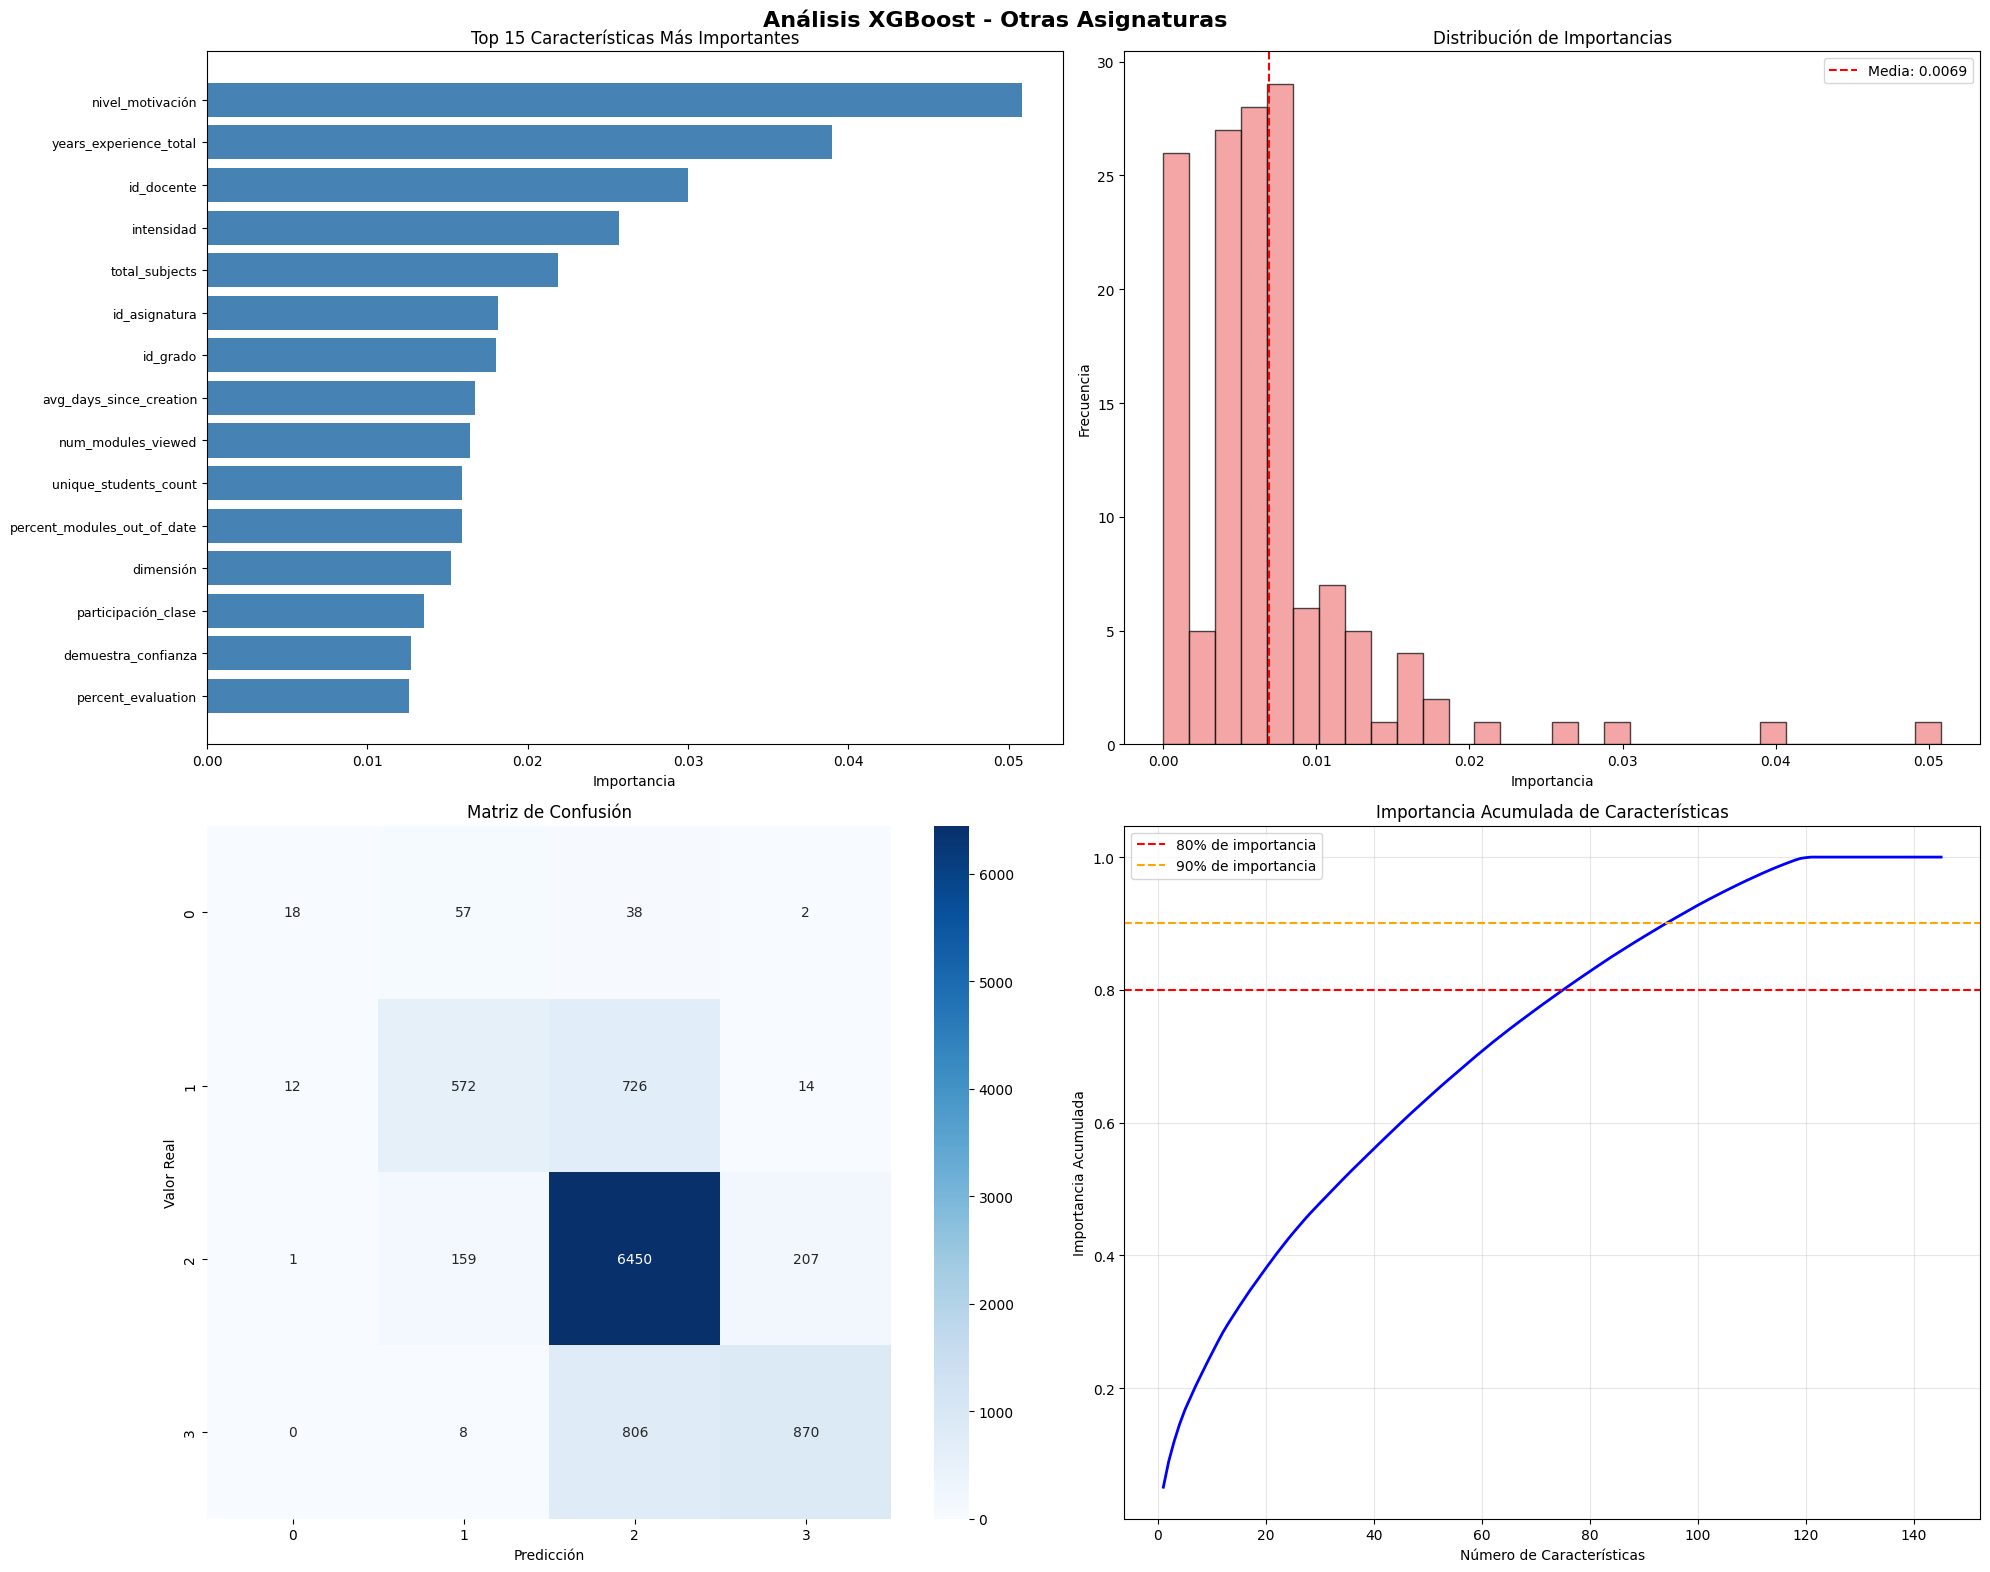

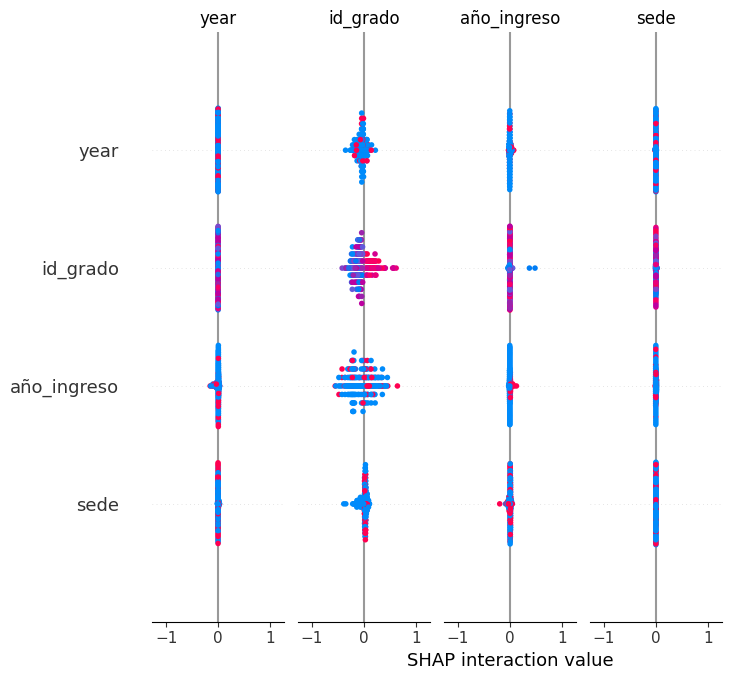

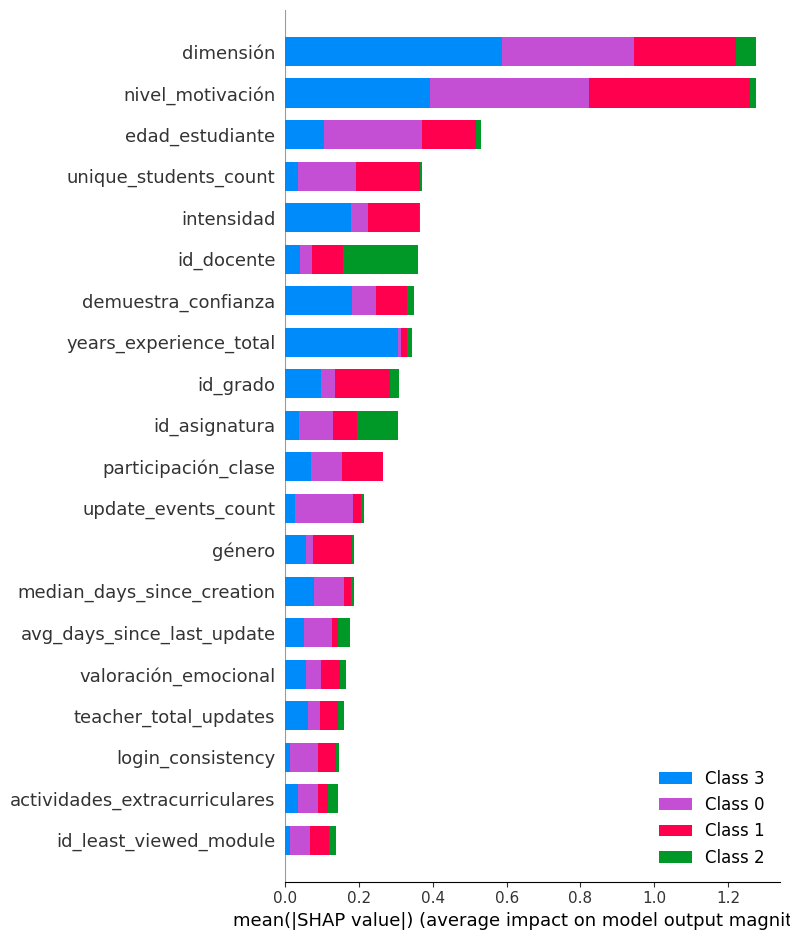


📊 Reporte de Clasificación para Otras Asignaturas:
              precision    recall  f1-score   support

        Alto       0.80      0.95      0.87      6817
        Bajo       0.58      0.16      0.25       115
      Básico       0.72      0.43      0.54      1324
    Superior       0.80      0.52      0.63      1684

    accuracy                           0.80      9940
   macro avg       0.72      0.51      0.57      9940
weighted avg       0.79      0.80      0.78      9940

✅ Importancia guardada en: feature_importance_otras_asignaturas.csv

📋 RESUMEN COMPARATIVO FINAL

🎯 Asignaturas Básicas:
   - Asignaturas analizadas: [1, 2, 3, 4]
   - Total de registros: 27135
   - Precisión del modelo: 0.7787
   - Top 5 características más importantes:
     25. nivel_motivación: 0.0397
     28. dimensión: 0.0330
     50. years_experience_ficc: 0.0322
     8. demuestra_confianza: 0.0237
     45. nivel_educativo: 0.0212

🎯 Otras Asignaturas:
   - Asignaturas analizadas: [np.int64(5), np.int6

In [13]:
main()